In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 200
beta = torch.linspace(0.005, 0.08, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9500e-01, 9.8965e-01, 9.8396e-01, 9.7792e-01, 9.7156e-01, 9.6487e-01,
        9.5786e-01, 9.5055e-01, 9.4293e-01, 9.3502e-01, 9.2682e-01, 9.1834e-01,
        9.0960e-01, 9.0059e-01, 8.9134e-01, 8.8184e-01, 8.7211e-01, 8.6217e-01,
        8.5201e-01, 8.4165e-01, 8.3109e-01, 8.2036e-01, 8.0946e-01, 7.9839e-01,
        7.8718e-01, 7.7583e-01, 7.6434e-01, 7.5274e-01, 7.4104e-01, 7.2923e-01,
        7.1734e-01, 7.0537e-01, 6.9334e-01, 6.8125e-01, 6.6911e-01, 6.5694e-01,
        6.4474e-01, 6.3253e-01, 6.2031e-01, 6.0809e-01, 5.9588e-01, 5.8369e-01,
        5.7154e-01, 5.5942e-01, 5.4734e-01, 5.3532e-01, 5.2337e-01, 5.1148e-01,
        4.9967e-01, 4.8794e-01, 4.7631e-01, 4.6477e-01, 4.5334e-01, 4.4202e-01,
        4.3081e-01, 4.1973e-01, 4.0877e-01, 3.9794e-01, 3.8726e-01, 3.7671e-01,
        3.6631e-01, 3.5605e-01, 3.4595e-01, 3.3601e-01, 3.2622e-01, 3.1660e-01,
        3.0714e-01, 2.9785e-01, 2.8873e-01, 2.7978e-01, 2.7100e-01, 2.6239e-01,
        2.5396e-01, 2.4570e-01, 2.3762e-

torch.Size([4, 3, 72, 72])


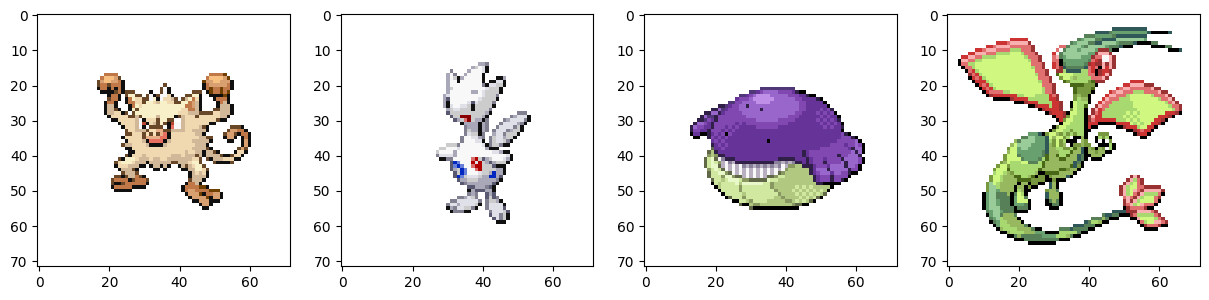

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Dark"], ["Fairy"], ["Electric"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

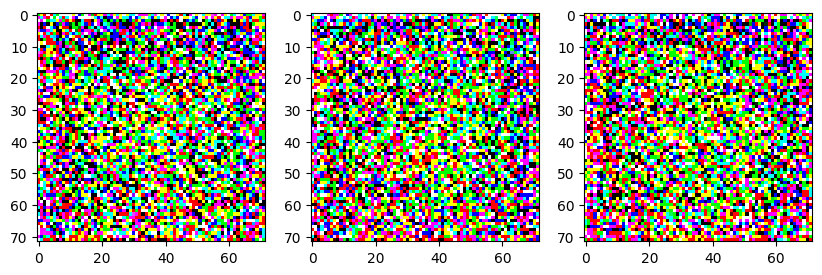

0.04993688:   1%|          | 1000/100001 [00:41<1:05:58, 25.01it/s]

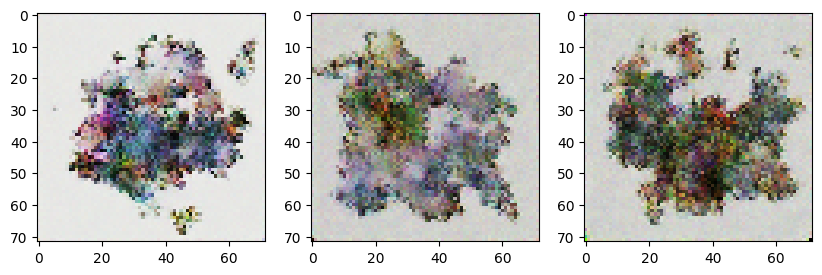

0.05583140:   2%|▏         | 1999/100001 [01:22<1:05:38, 24.89it/s]

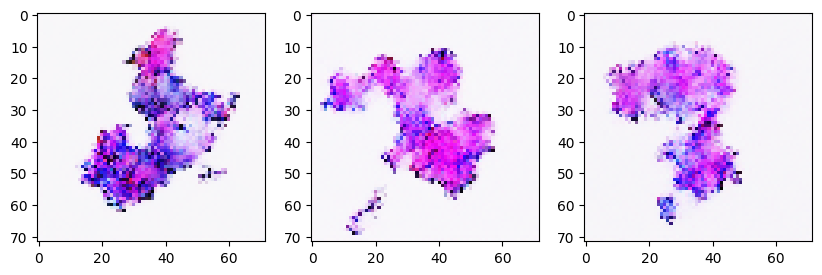

0.06381321:   3%|▎         | 2998/100001 [02:03<1:04:51, 24.93it/s]

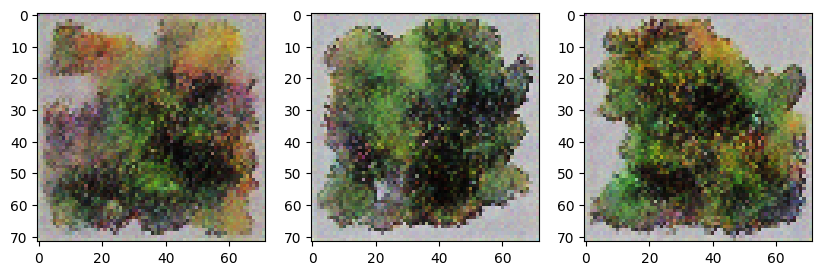

0.03972436:   4%|▍         | 4000/100001 [02:45<1:04:19, 24.87it/s]

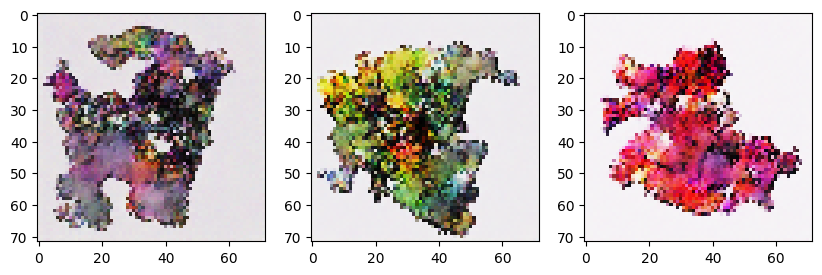

0.05400408:   5%|▍         | 4999/100001 [03:26<1:03:39, 24.87it/s]

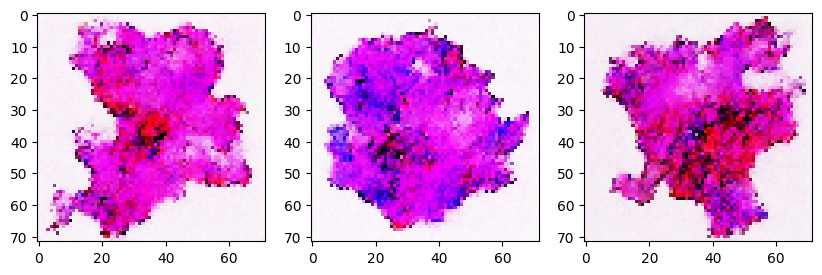

0.03747617:   6%|▌         | 5998/100001 [04:07<1:03:06, 24.82it/s]

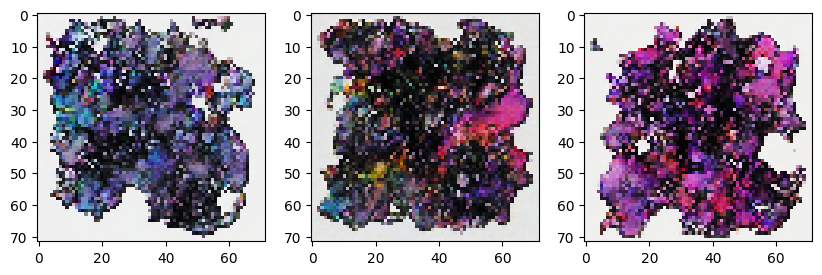

0.04624612:   7%|▋         | 7000/100001 [04:48<1:02:19, 24.87it/s]

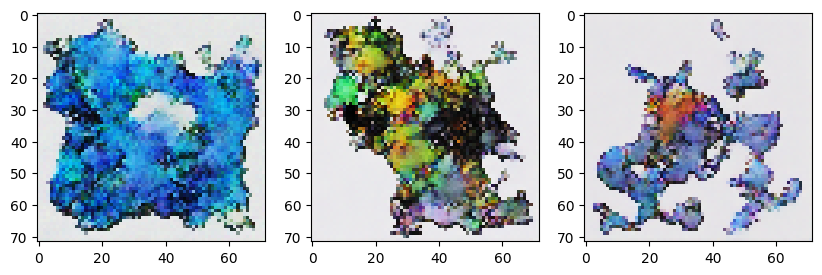

0.03342303:   8%|▊         | 7999/100001 [05:30<1:01:44, 24.84it/s]

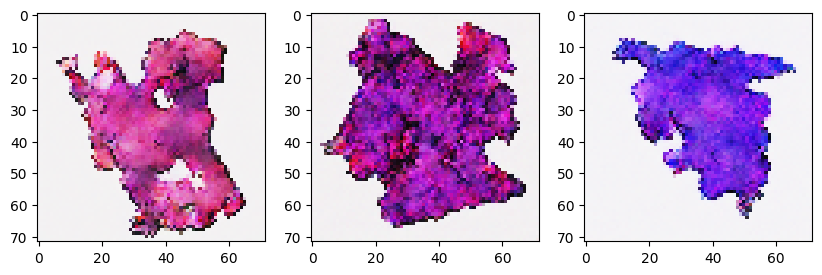

0.02054296:   9%|▉         | 8998/100001 [06:11<1:00:54, 24.90it/s]

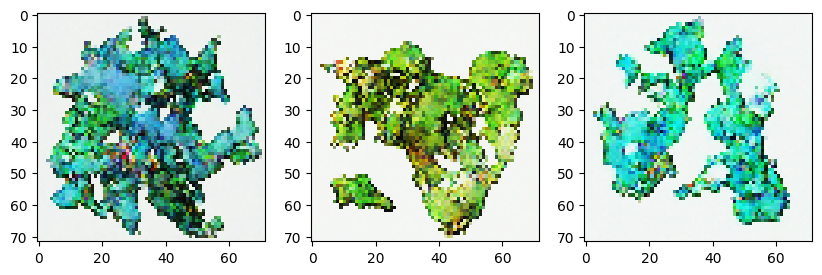

0.05296203:  10%|▉         | 10000/100001 [06:52<1:00:19, 24.86it/s]

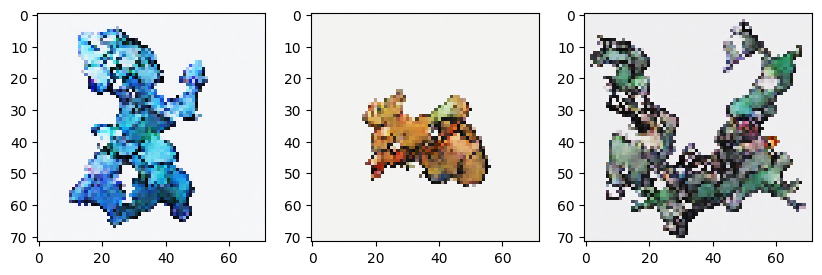

0.04486989:  11%|█         | 10999/100001 [07:33<59:34, 24.90it/s]  

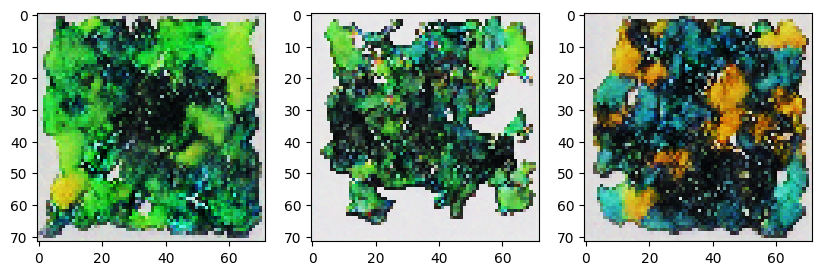

0.05104570:  12%|█▏        | 11998/100001 [08:14<58:59, 24.86it/s]  

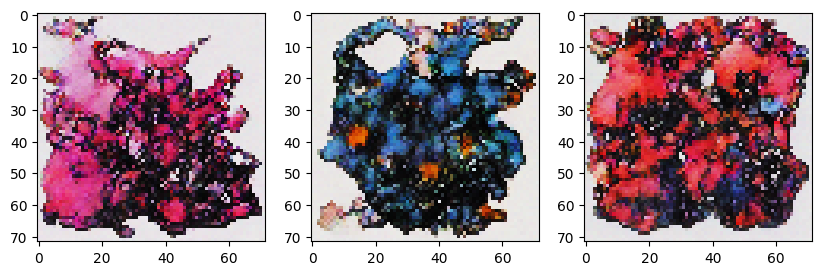

0.05526258:  13%|█▎        | 13000/100001 [08:56<58:23, 24.84it/s]  

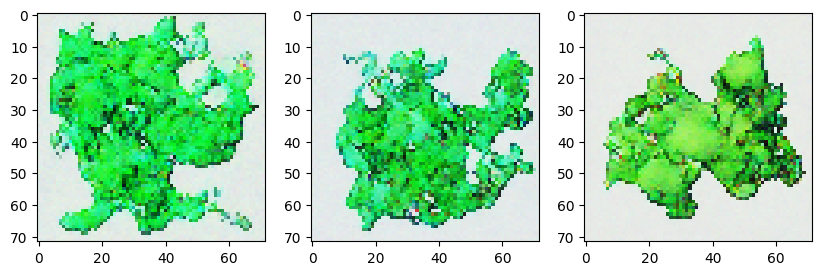

0.02622596:  14%|█▍        | 13999/100001 [09:37<57:25, 24.96it/s]  

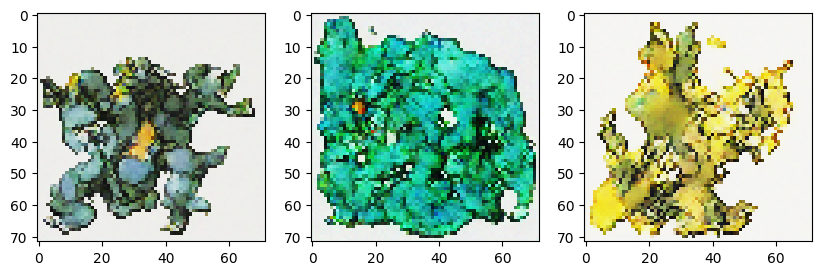

0.03737346:  15%|█▍        | 14998/100001 [10:18<56:48, 24.94it/s]  

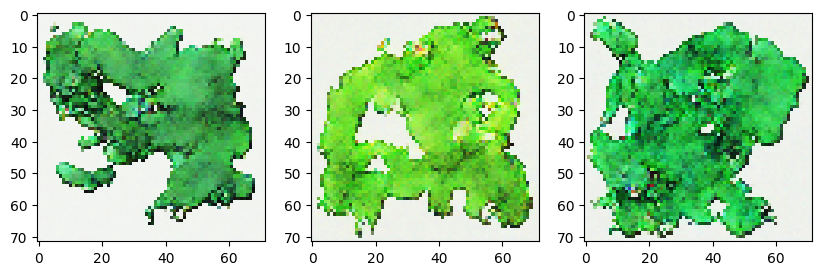

0.02336163:  16%|█▌        | 16000/100001 [10:59<56:20, 24.85it/s]  

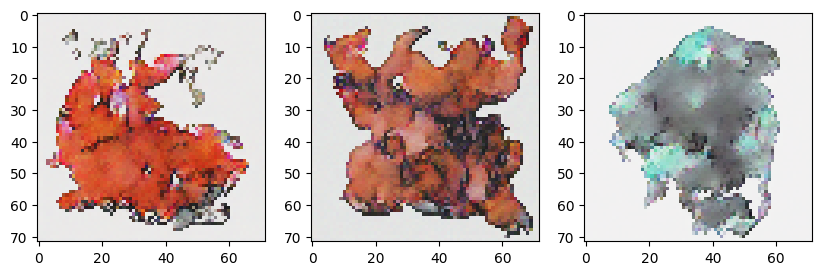

0.04947804:  17%|█▋        | 16999/100001 [11:40<55:31, 24.92it/s]  

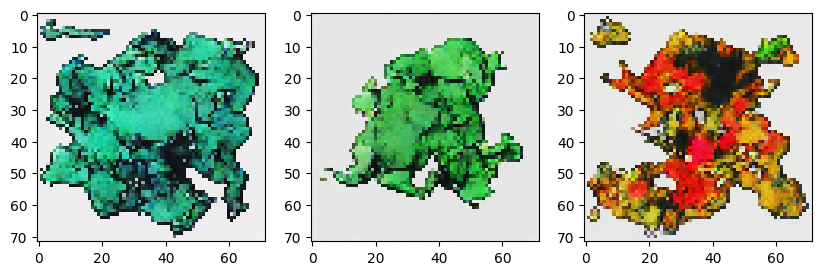

0.03128502:  18%|█▊        | 17998/100001 [12:21<54:54, 24.89it/s]  

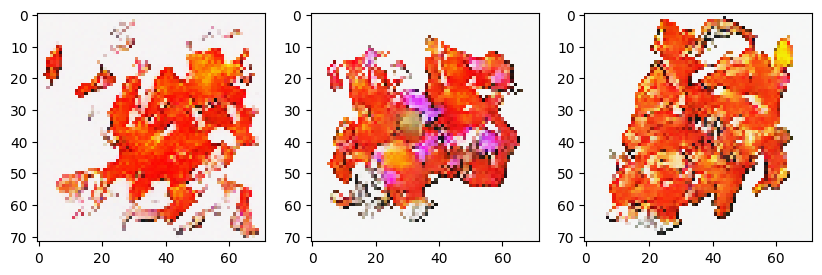

0.04549504:  19%|█▉        | 19000/100001 [13:03<54:15, 24.88it/s]  

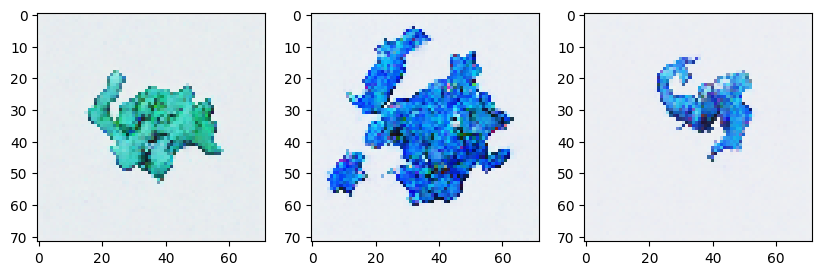

0.03780537:  20%|█▉        | 19999/100001 [13:44<53:41, 24.83it/s]  

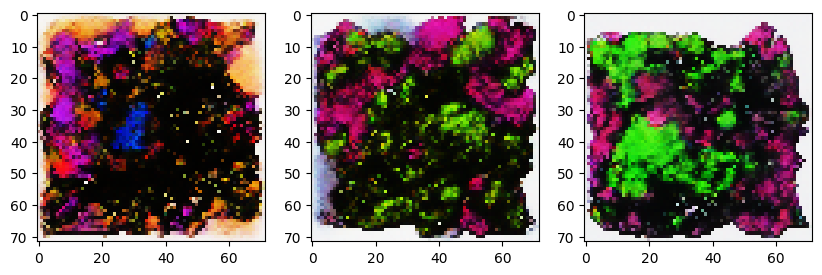

0.01578761:  21%|██        | 20998/100001 [14:25<53:00, 24.84it/s]  

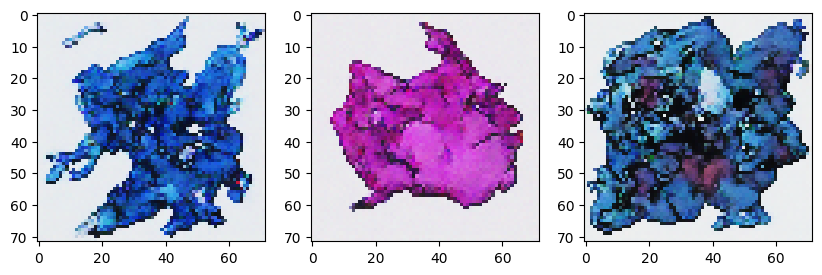

0.03130990:  22%|██▏       | 22000/100001 [15:06<52:20, 24.83it/s]  

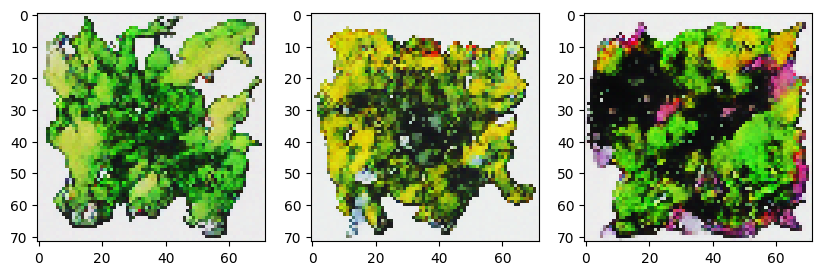

0.02163615:  23%|██▎       | 22999/100001 [15:47<51:32, 24.90it/s]  

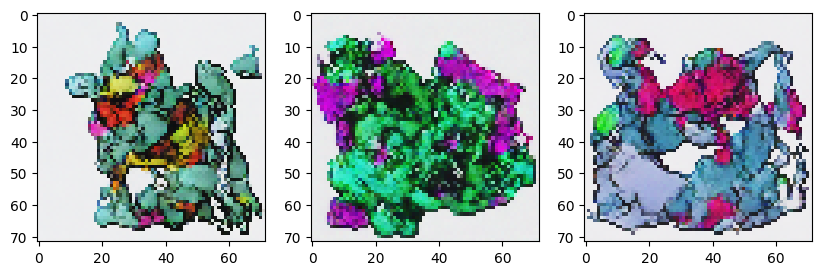

0.02821130:  24%|██▍       | 23998/100001 [16:29<50:57, 24.86it/s]  

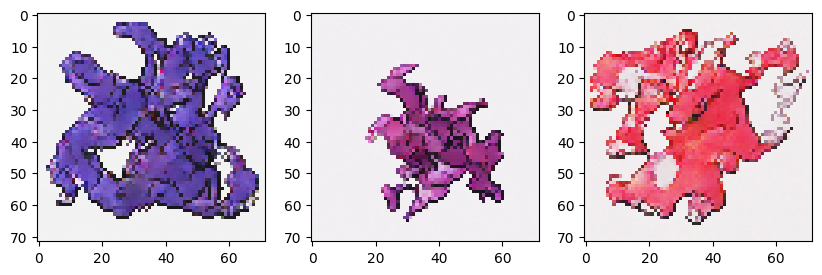

0.02448821:  25%|██▍       | 25000/100001 [17:10<50:05, 24.96it/s]  

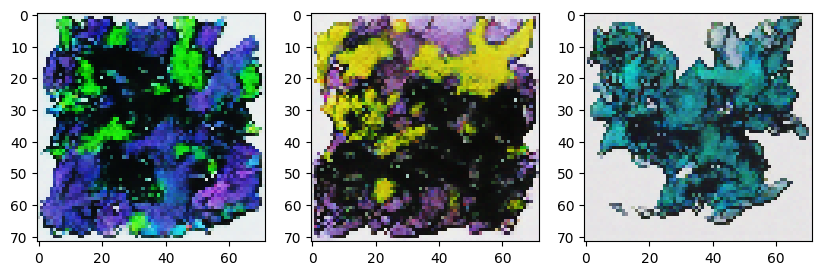

0.01736254:  26%|██▌       | 25999/100001 [17:51<49:19, 25.01it/s]  

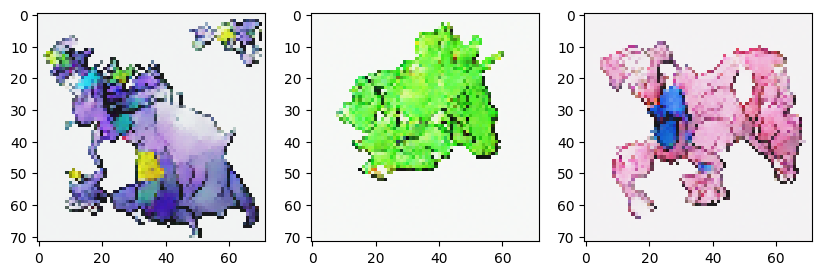

0.03484837:  27%|██▋       | 26998/100001 [18:32<48:58, 24.84it/s]  

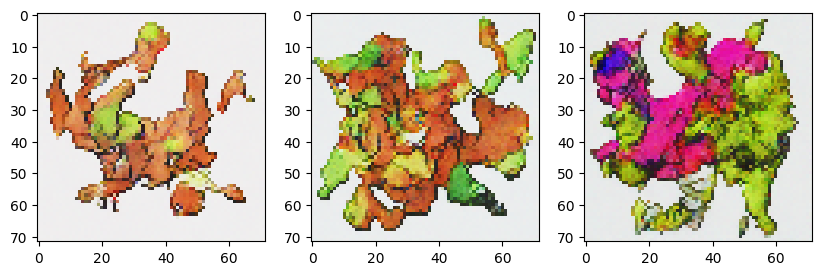

0.02073264:  28%|██▊       | 28000/100001 [19:13<48:07, 24.94it/s]  

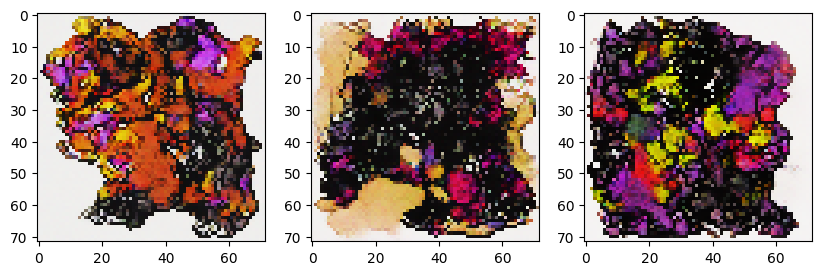

0.04196974:  29%|██▉       | 28999/100001 [19:54<47:19, 25.00it/s]  

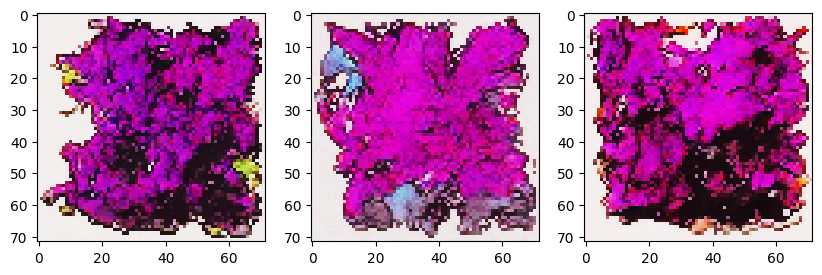

0.02673759:  30%|██▉       | 29998/100001 [20:35<46:48, 24.92it/s]  

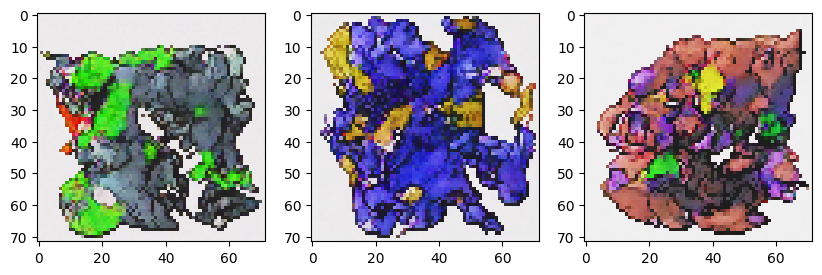

0.04924998:  31%|███       | 31000/100001 [21:17<46:10, 24.91it/s]  

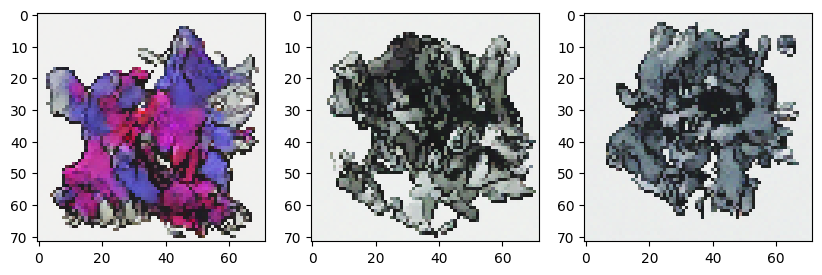

0.03485830:  32%|███▏      | 31999/100001 [21:58<45:28, 24.93it/s]  

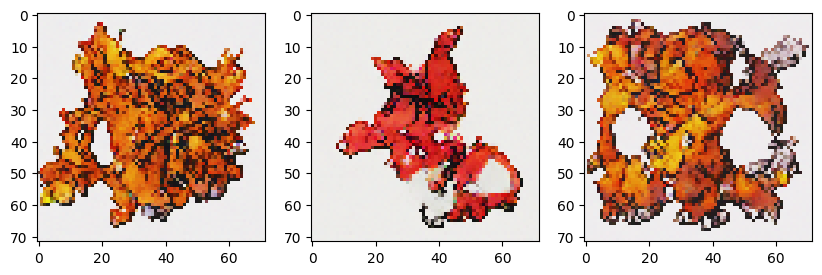

0.02499501:  33%|███▎      | 32998/100001 [22:39<44:47, 24.93it/s]  

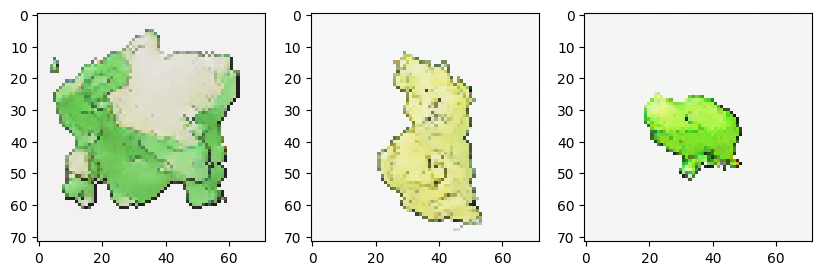

0.01488760:  34%|███▍      | 34000/100001 [23:21<44:17, 24.83it/s]  

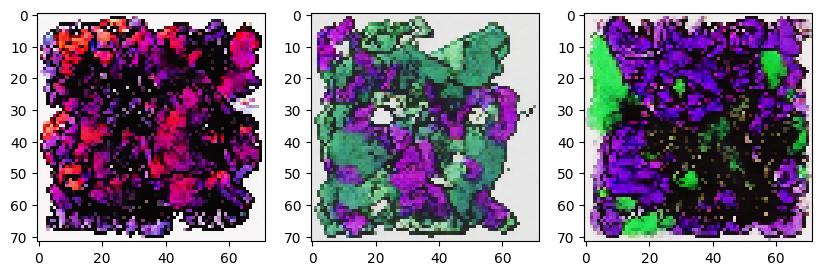

0.02231917:  35%|███▍      | 34999/100001 [24:02<43:21, 24.99it/s]  

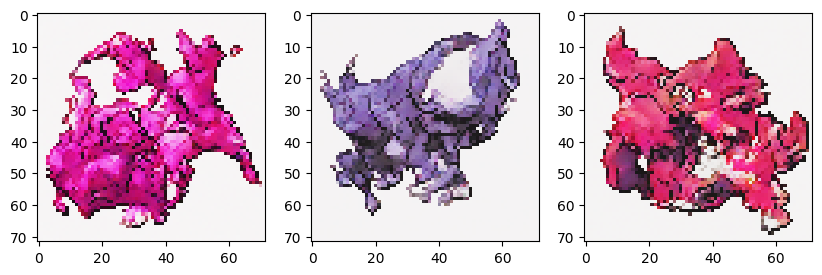

0.02887824:  36%|███▌      | 35998/100001 [24:43<42:50, 24.90it/s]  

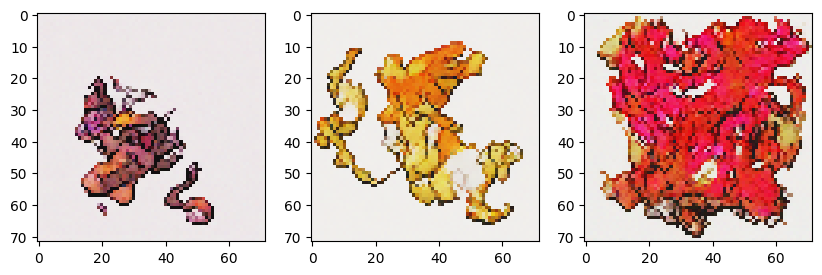

0.02100999:  37%|███▋      | 37000/100001 [25:24<42:15, 24.85it/s]  

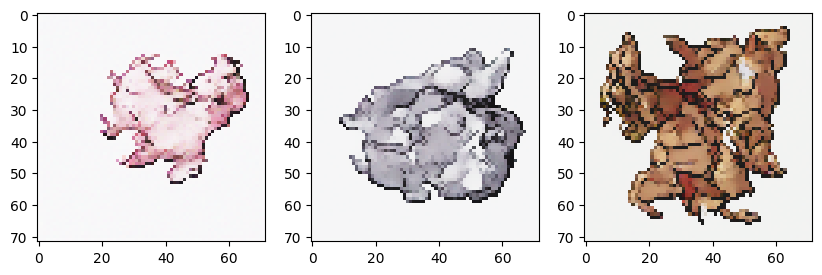

0.02318029:  38%|███▊      | 37999/100001 [26:06<41:22, 24.98it/s]  

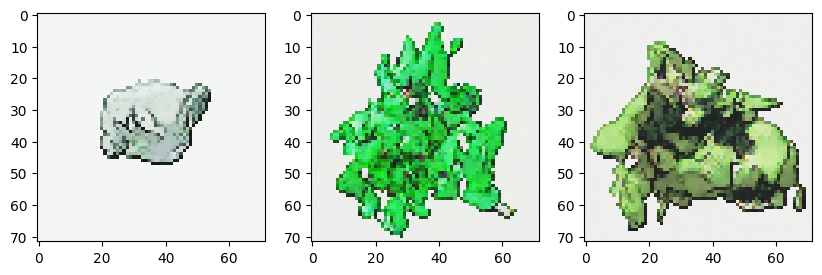

0.01662086:  39%|███▉      | 38998/100001 [26:47<40:47, 24.92it/s]  

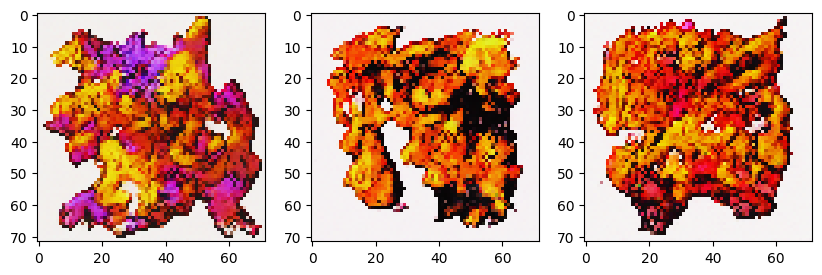

0.02293531:  40%|███▉      | 40000/100001 [27:28<40:15, 24.84it/s]  

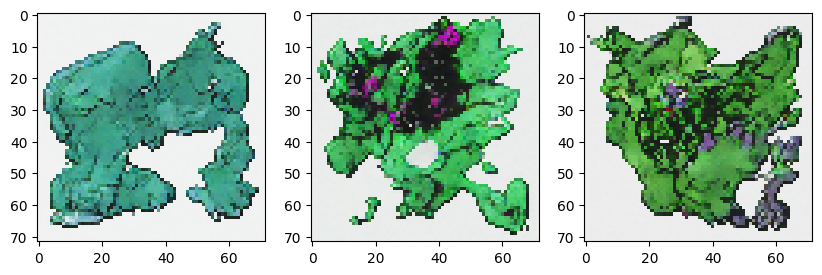

0.01975217:  41%|████      | 40999/100001 [28:09<39:30, 24.89it/s]  

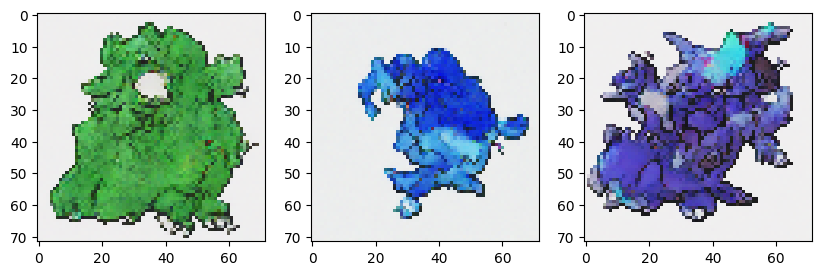

0.03129563:  42%|████▏     | 41998/100001 [28:50<38:50, 24.89it/s]  

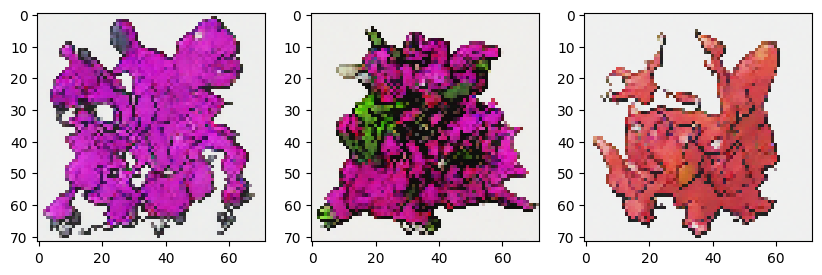

0.02850210:  43%|████▎     | 43000/100001 [29:32<38:05, 24.94it/s]  

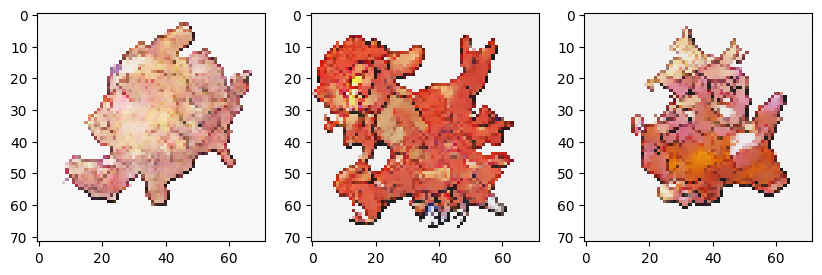

0.02269662:  44%|████▍     | 43999/100001 [30:13<37:21, 24.99it/s]  

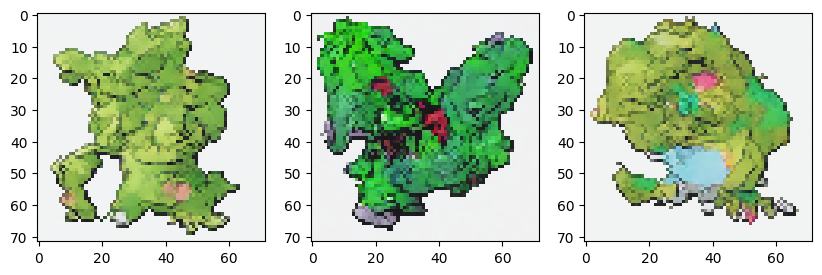

0.03095053:  45%|████▍     | 44998/100001 [30:54<36:44, 24.95it/s]  

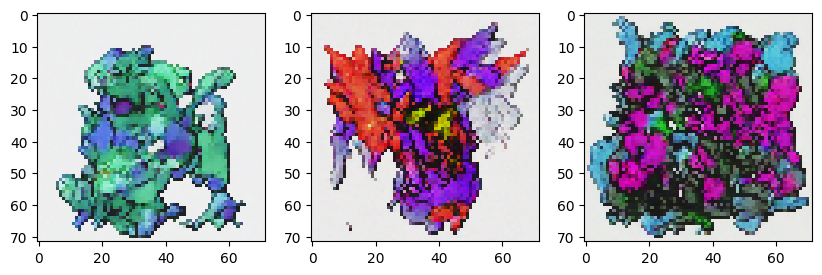

0.02497934:  46%|████▌     | 46000/100001 [31:35<36:04, 24.95it/s]  

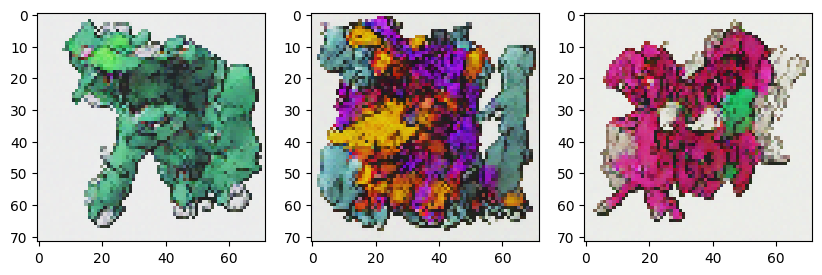

0.02288864:  47%|████▋     | 46999/100001 [32:16<35:21, 24.98it/s]  

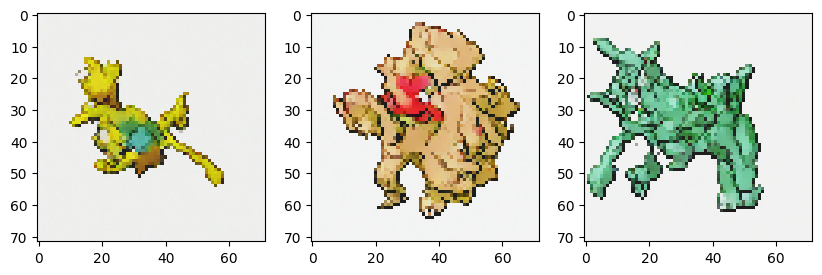

0.03110620:  48%|████▊     | 47998/100001 [32:58<34:55, 24.82it/s]  

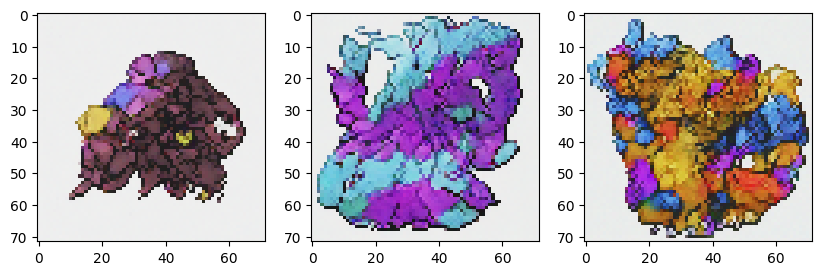

0.02710123:  49%|████▉     | 49000/100001 [33:39<34:12, 24.85it/s]  

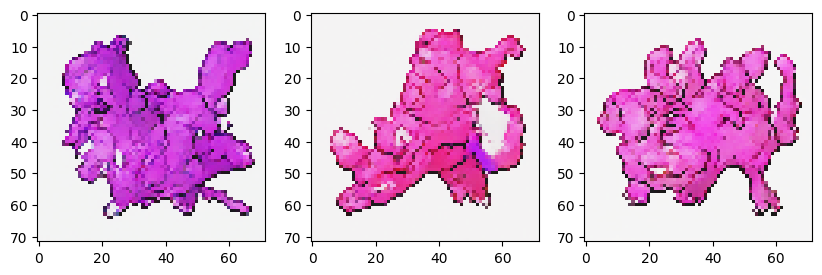

0.03942836:  50%|████▉     | 49999/100001 [34:20<33:22, 24.97it/s]  

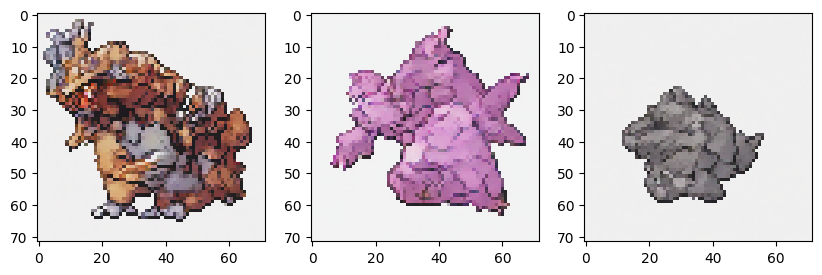

0.01331376:  51%|█████     | 50998/100001 [35:01<32:49, 24.88it/s]  

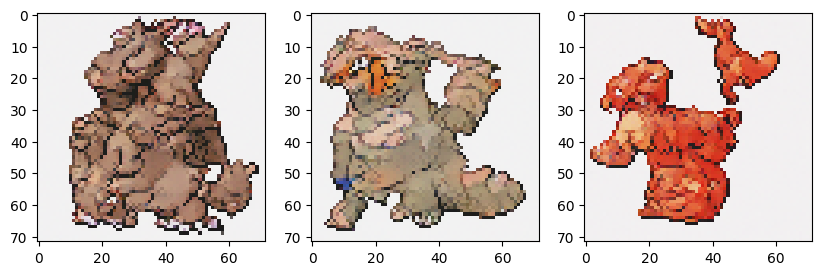

0.04516459:  52%|█████▏    | 52000/100001 [35:42<32:00, 25.00it/s]  

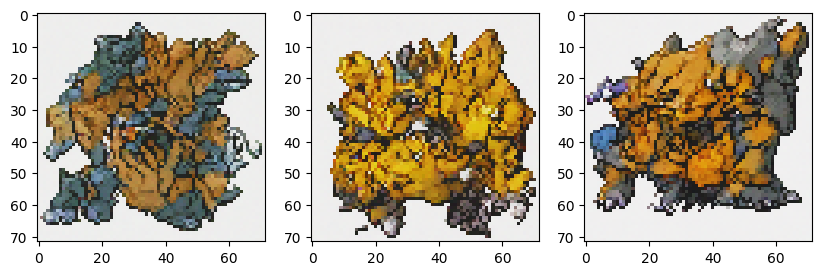

0.03405443:  53%|█████▎    | 52999/100001 [36:24<31:19, 25.00it/s]  

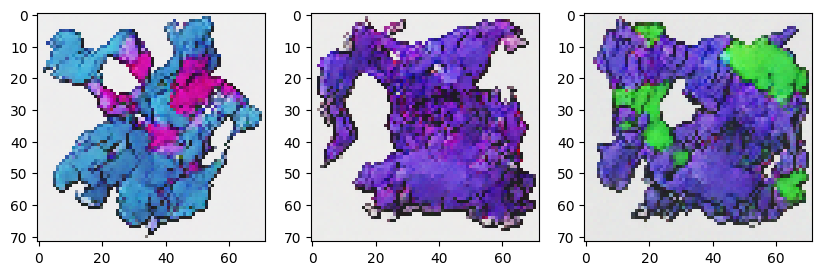

0.01837577:  54%|█████▍    | 53998/100001 [37:05<30:44, 24.94it/s]  

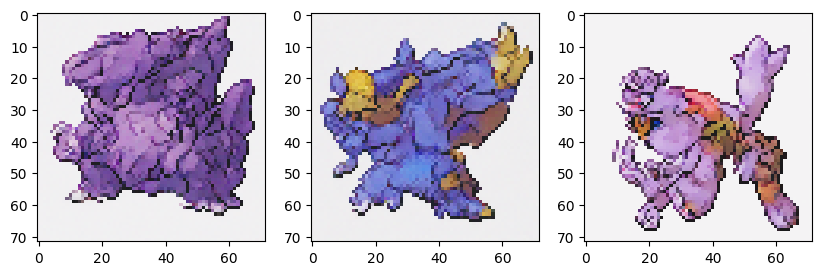

0.01725900:  55%|█████▍    | 55000/100001 [37:46<30:07, 24.89it/s]  

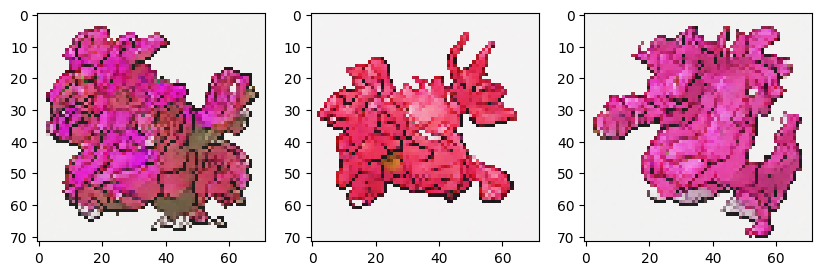

0.03730926:  56%|█████▌    | 55999/100001 [38:27<29:31, 24.84it/s]  

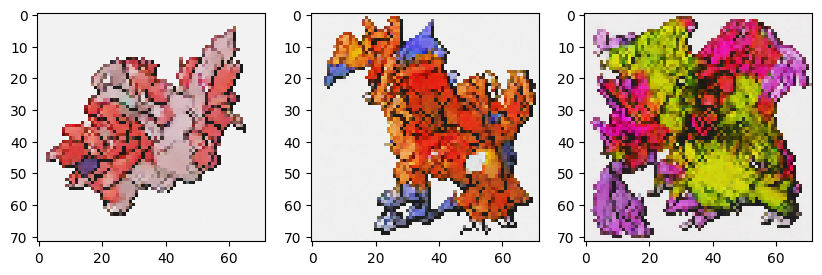

0.01883878:  57%|█████▋    | 56998/100001 [39:08<28:46, 24.90it/s]  

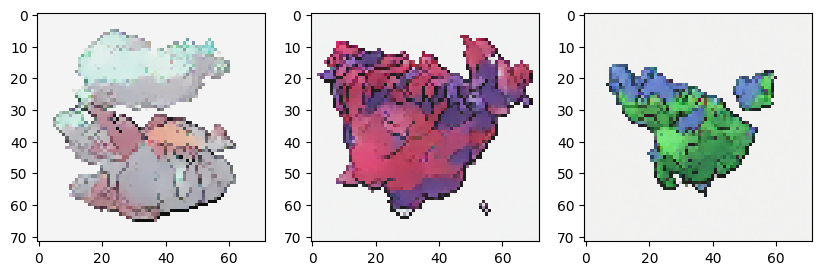

0.02258191:  58%|█████▊    | 58000/100001 [39:50<28:04, 24.94it/s]  

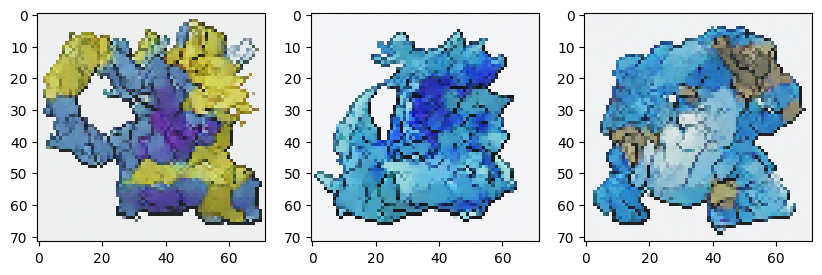

0.01910185:  59%|█████▉    | 58999/100001 [40:31<27:29, 24.86it/s]  

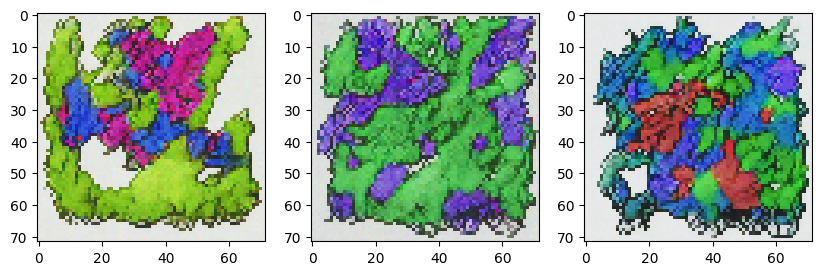

0.01654610:  60%|█████▉    | 59998/100001 [41:12<26:42, 24.96it/s]  

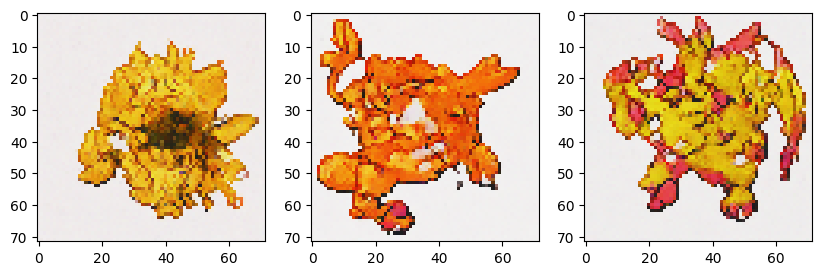

0.02742857:  61%|██████    | 61000/100001 [41:53<25:59, 25.01it/s]  

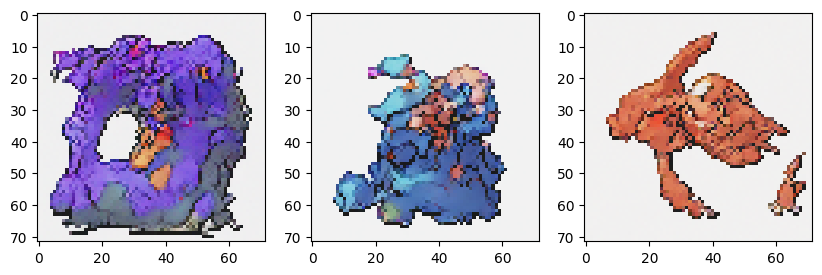

0.02291870:  62%|██████▏   | 61999/100001 [42:34<25:28, 24.87it/s]  

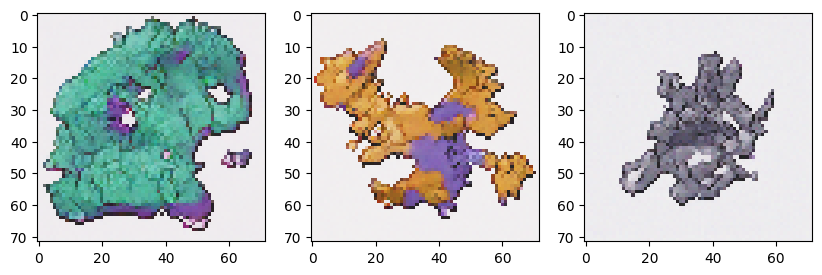

0.01921756:  63%|██████▎   | 62998/100001 [43:15<24:45, 24.90it/s]  

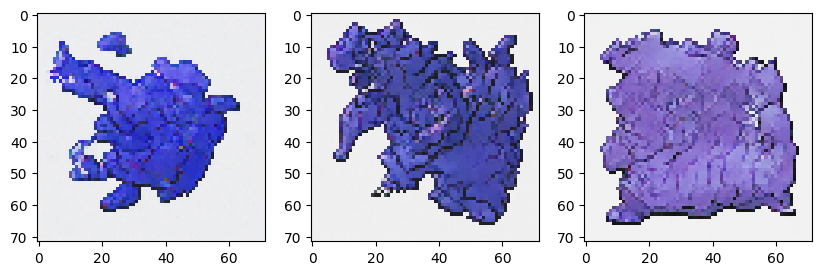

0.02115011:  64%|██████▍   | 64000/100001 [43:57<24:00, 25.00it/s]  

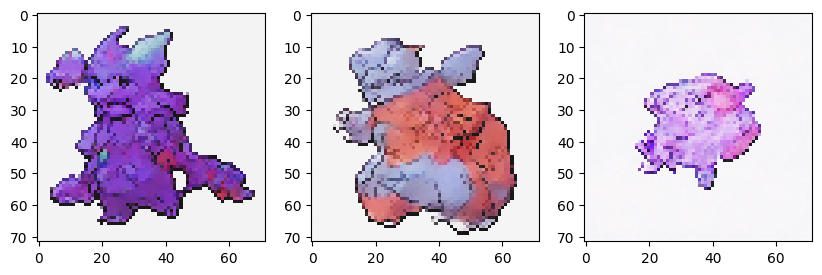

0.03994182:  65%|██████▍   | 64999/100001 [44:38<23:26, 24.89it/s]  

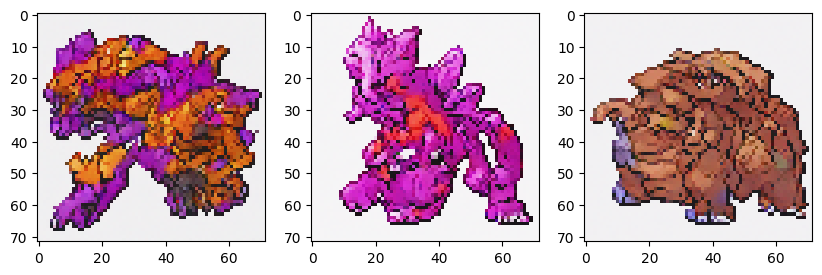

0.02687863:  66%|██████▌   | 65998/100001 [45:19<22:48, 24.84it/s]  

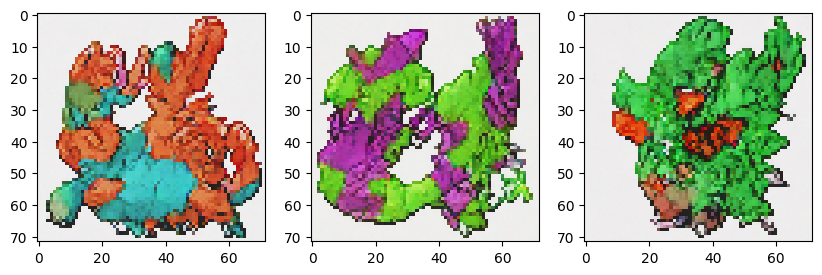

0.03341208:  67%|██████▋   | 67000/100001 [46:00<22:01, 24.98it/s]  

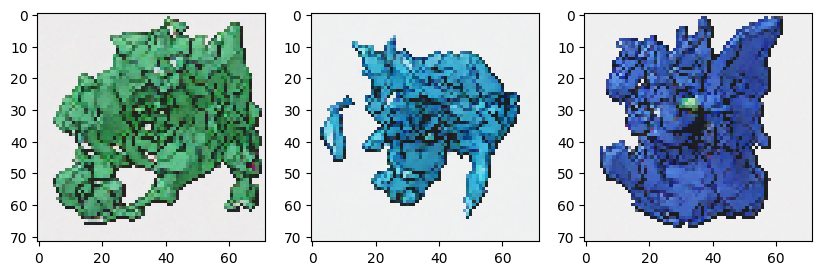

0.01910324:  68%|██████▊   | 67999/100001 [46:42<21:26, 24.87it/s]  

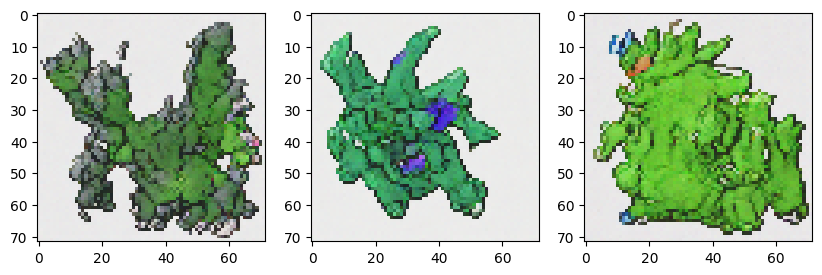

0.02654204:  69%|██████▉   | 68998/100001 [47:23<20:45, 24.89it/s]  

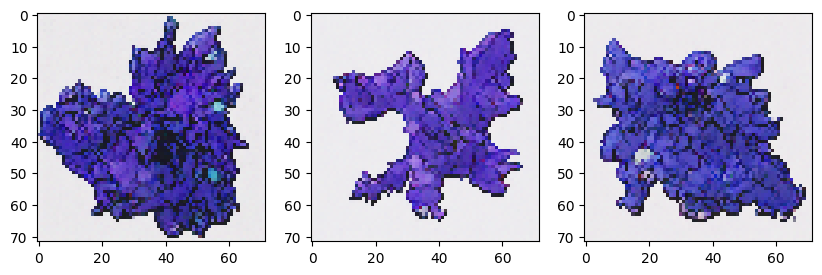

0.01533363:  70%|██████▉   | 70000/100001 [48:04<20:08, 24.83it/s]  

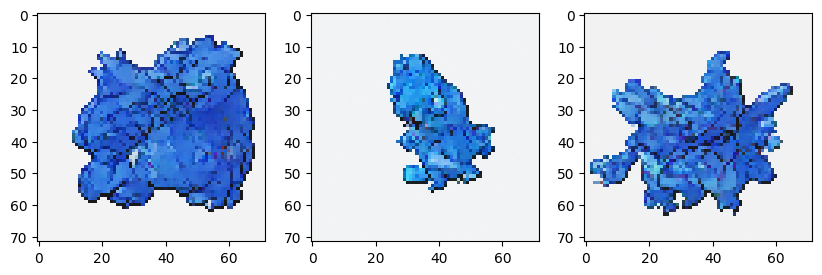

0.01410841:  71%|███████   | 70999/100001 [48:45<19:23, 24.94it/s]  

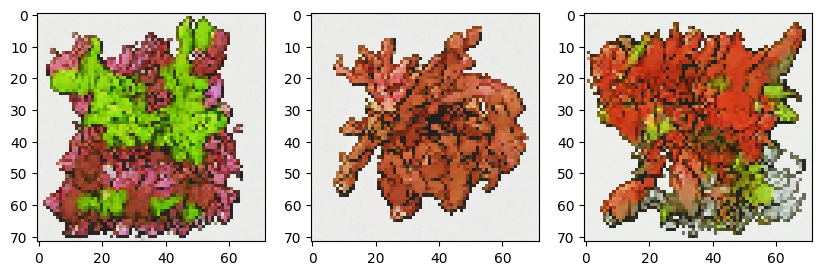

0.00949644:  72%|███████▏  | 71998/100001 [49:26<18:44, 24.90it/s]  

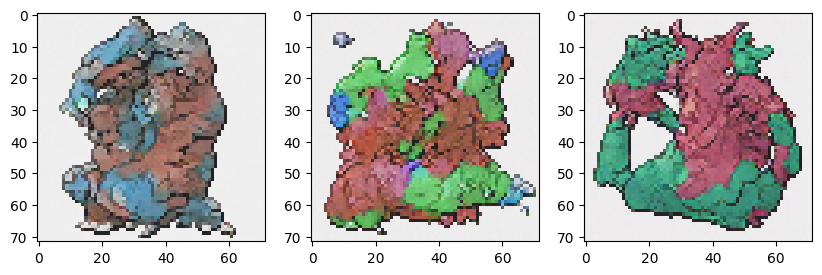

0.01674097:  73%|███████▎  | 73000/100001 [50:08<18:05, 24.88it/s]  

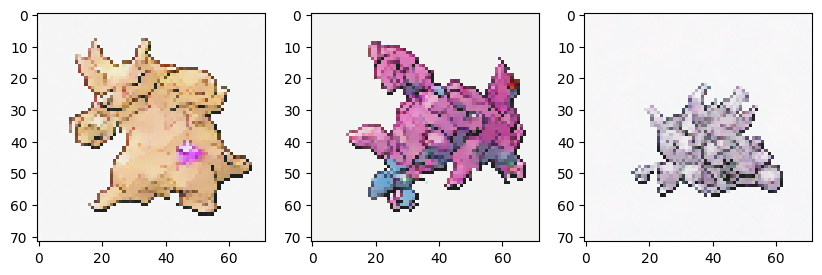

0.02099924:  74%|███████▍  | 73999/100001 [50:49<17:27, 24.82it/s]  

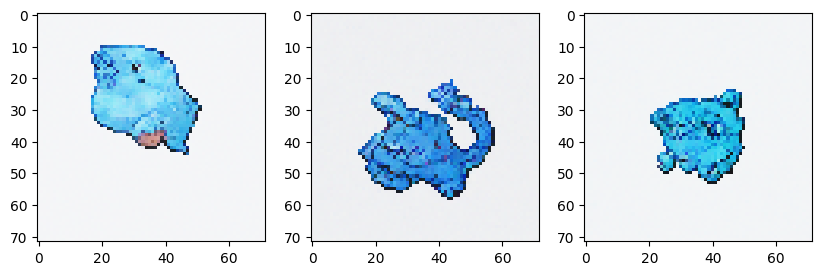

0.02600045:  75%|███████▍  | 74998/100001 [51:30<16:42, 24.95it/s]  

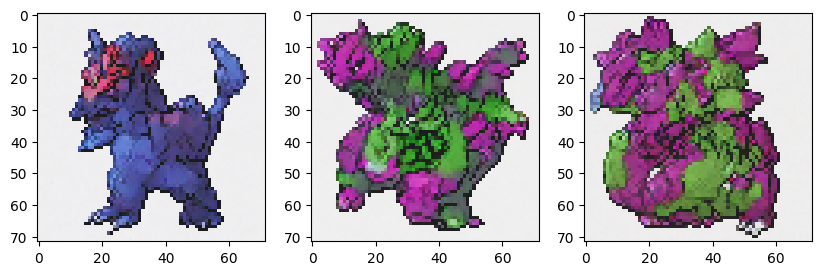

0.01203170:  76%|███████▌  | 76000/100001 [52:11<16:05, 24.86it/s]  

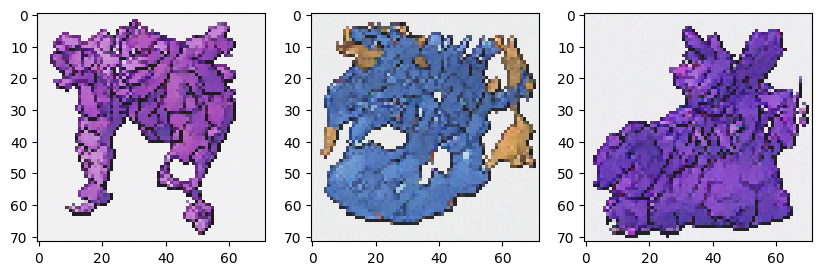

0.02431964:  77%|███████▋  | 76999/100001 [52:53<15:28, 24.78it/s]

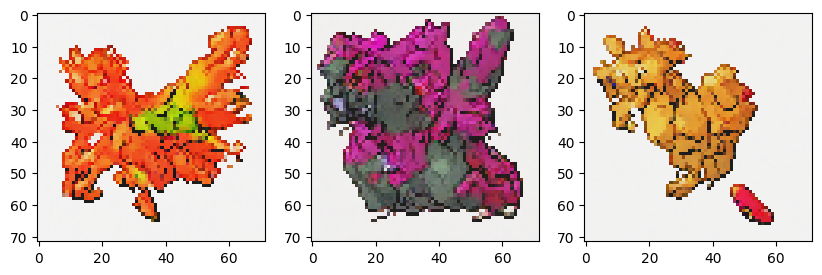

0.02395115:  78%|███████▊  | 77998/100001 [53:34<14:43, 24.91it/s]

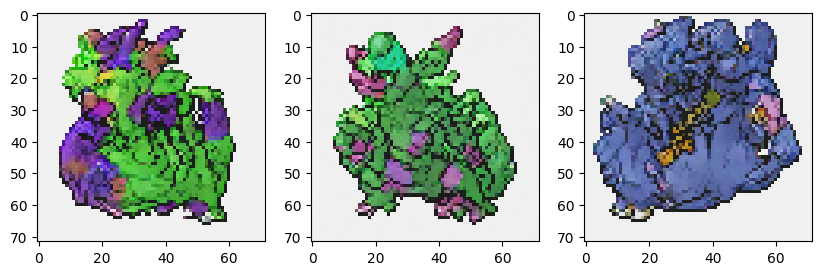

0.01703256:  79%|███████▉  | 79000/100001 [54:16<14:06, 24.80it/s]

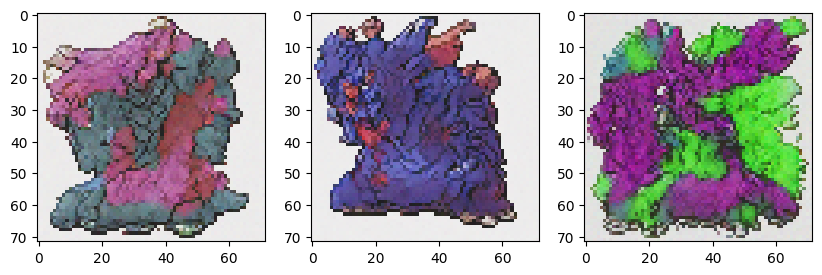

0.03398277:  80%|███████▉  | 79999/100001 [54:57<13:25, 24.83it/s]

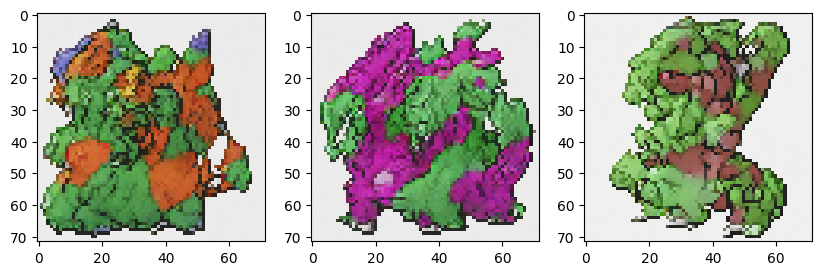

0.01270329:  81%|████████  | 80998/100001 [55:38<12:40, 25.00it/s]

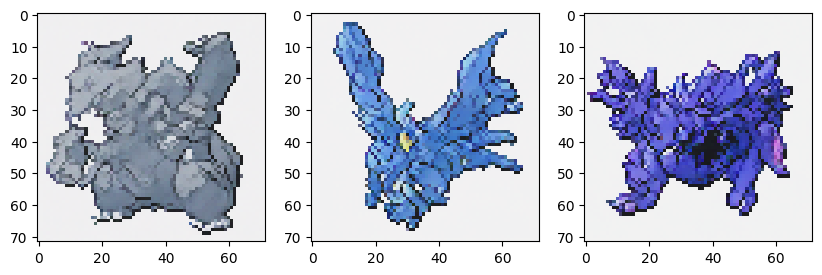

0.02024507:  82%|████████▏ | 82000/100001 [56:19<12:04, 24.85it/s]

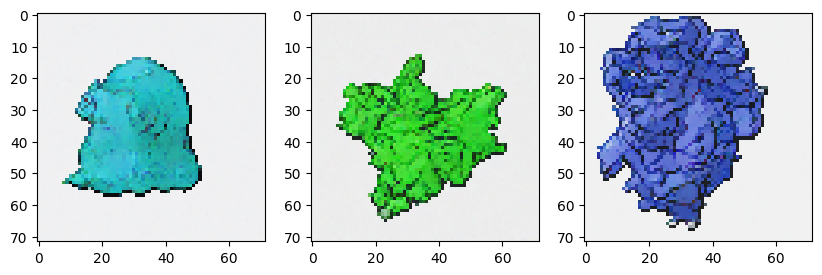

0.01530617:  83%|████████▎ | 82999/100001 [57:01<11:24, 24.85it/s]

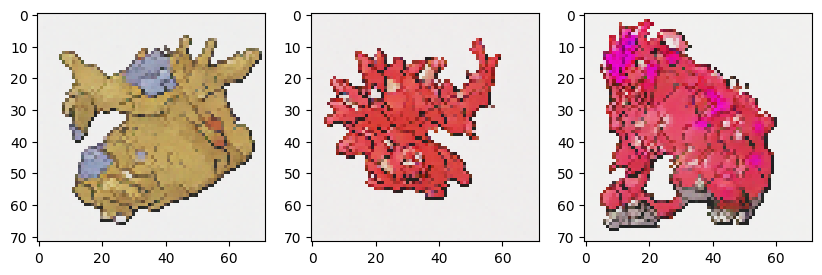

0.02786663:  84%|████████▍ | 83998/100001 [57:42<10:44, 24.83it/s]

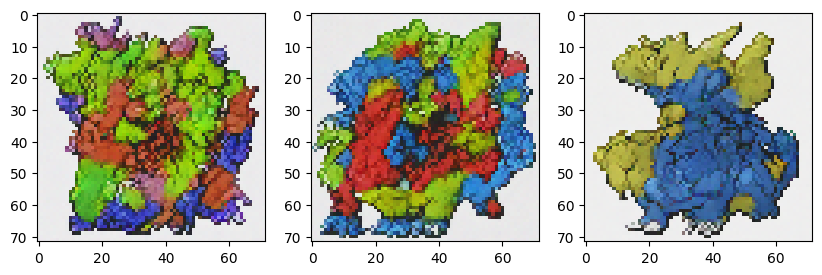

0.01650364:  85%|████████▍ | 85000/100001 [58:23<10:01, 24.94it/s]

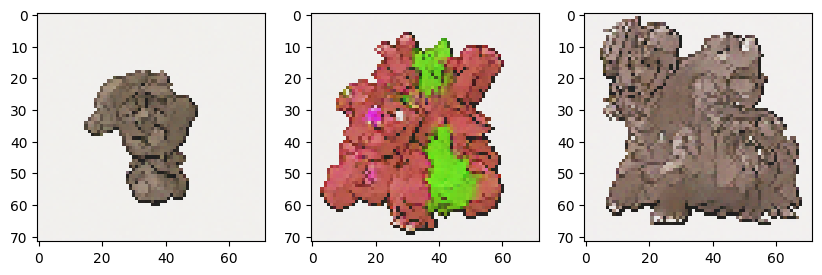

0.02501952:  86%|████████▌ | 85999/100001 [59:04<09:22, 24.90it/s]

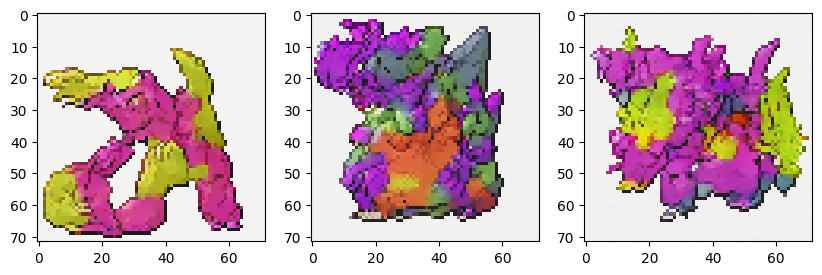

0.02449372:  87%|████████▋ | 86998/100001 [59:46<08:43, 24.84it/s]

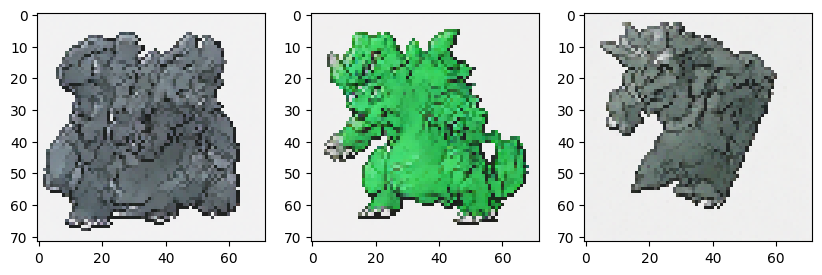

0.00870555:  88%|████████▊ | 88000/100001 [1:00:27<08:02, 24.85it/s]

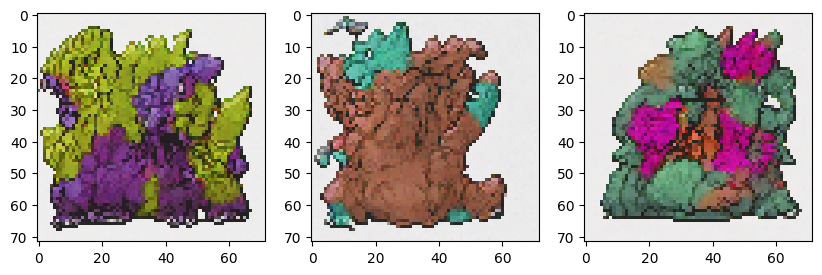

0.02485431:  89%|████████▉ | 88999/100001 [1:01:08<07:22, 24.89it/s]

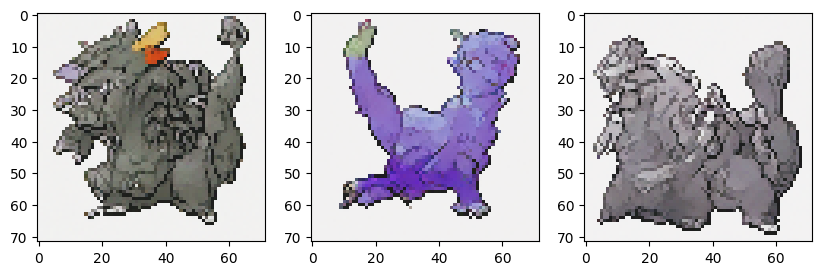

0.01220154:  90%|████████▉ | 89998/100001 [1:01:49<06:42, 24.88it/s]

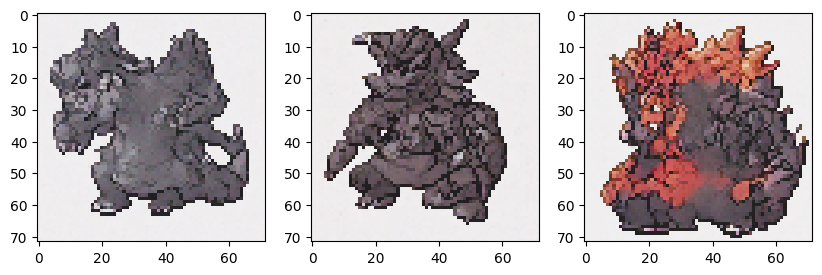

0.02032331:  91%|█████████ | 91000/100001 [1:02:31<06:01, 24.91it/s]

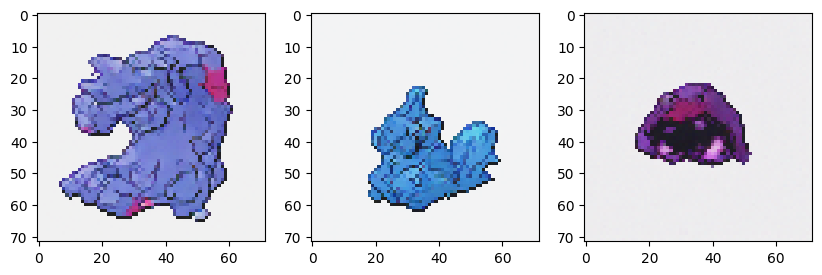

0.01852725:  92%|█████████▏| 91999/100001 [1:03:12<05:22, 24.82it/s]

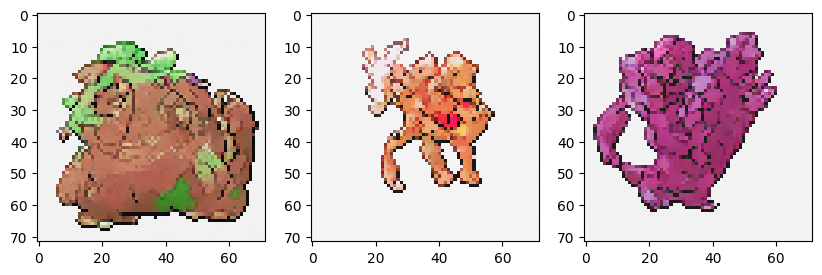

0.01563460:  93%|█████████▎| 92998/100001 [1:03:53<04:42, 24.82it/s]

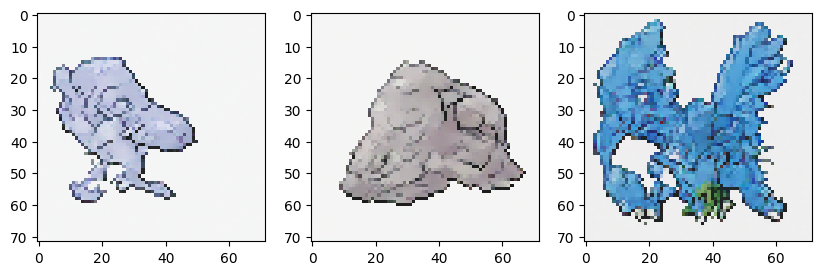

0.02137474:  94%|█████████▍| 94000/100001 [1:04:34<04:01, 24.88it/s]

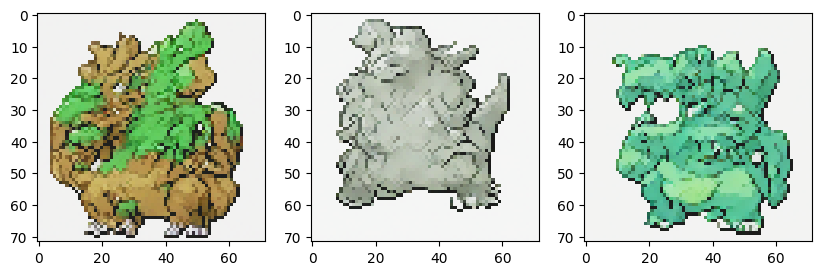

0.01224548:  95%|█████████▍| 94999/100001 [1:05:15<03:21, 24.81it/s]

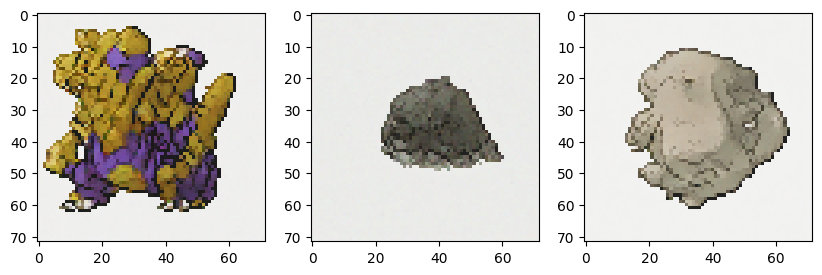

0.04200256:  96%|█████████▌| 95998/100001 [1:05:57<02:40, 24.92it/s]

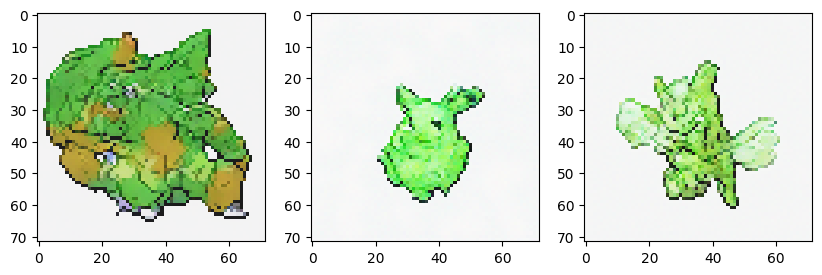

0.02446674:  97%|█████████▋| 97000/100001 [1:06:38<02:00, 24.98it/s]

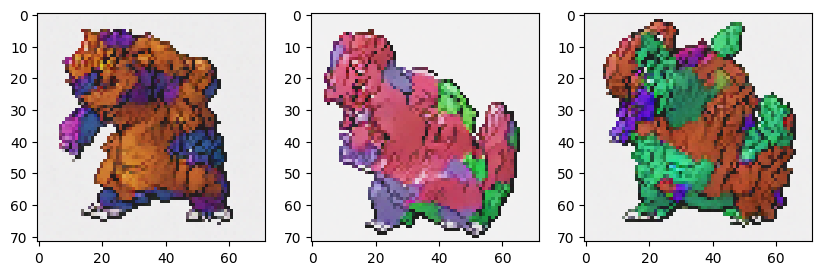

0.01246148:  98%|█████████▊| 97999/100001 [1:07:19<01:20, 24.95it/s]

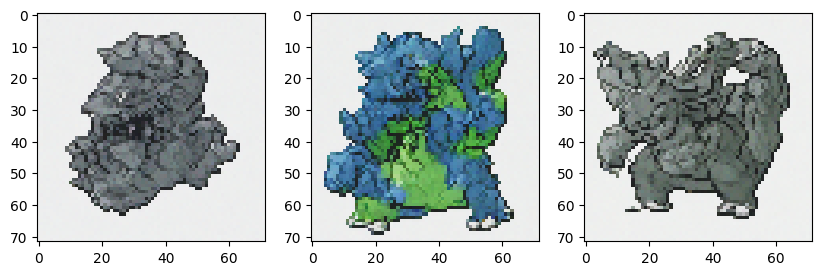

0.01372556:  99%|█████████▉| 98998/100001 [1:08:00<00:40, 25.02it/s]

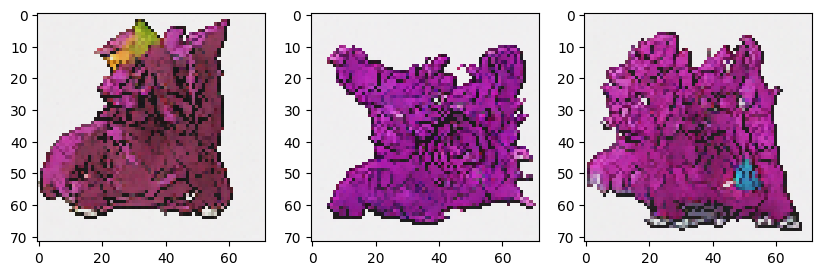

0.01288675: 100%|█████████▉| 100000/100001 [1:08:41<00:00, 24.88it/s]

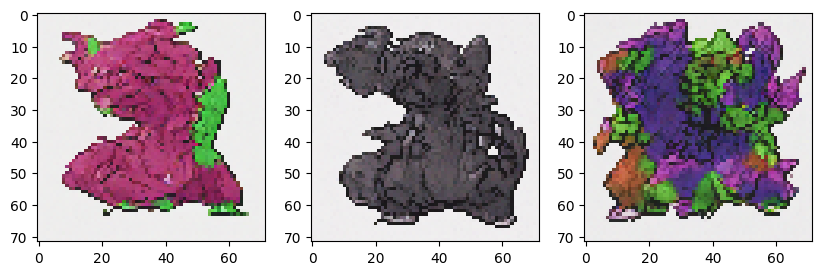

0.02386318: 100%|██████████| 100001/100001 [1:08:43<00:00, 24.25it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')